# Naive Bayesian Model implementation

In this notebook, we implement two Gaussian Naive Bayesian models using two kinds of features:
- **tf-idf** vectorized features.
- **hasing-vectorize** features.

For each model, we first build model on given constant and then using tunning to choose the most approriate hyperameters.

### Load dataset

In [1]:
import sys
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

# Add project root to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from data import Preprocessing, FeatureExtraction

# Define constants
MAX_FEATURES = 1000
MAX_GRAMS = 3
MIN_GRAMS = 1
N_FEATURES = 500

### Study dataset

In [2]:
import pandas as pd

prepro = Preprocessing()
feature_extraction = FeatureExtraction()
df: pd.DataFrame = prepro.read_CSV()

df = df[['textID', 'text', 'sentiment', 'Time of Tweet', 'Age of User']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3534 entries, 0 to 3533
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         3534 non-null   object
 1   text           3534 non-null   object
 2   sentiment      3534 non-null   object
 3   Time of Tweet  3534 non-null   object
 4   Age of User    3534 non-null   object
dtypes: object(5)
memory usage: 165.7+ KB


In [3]:
df.head()

,textID,text,sentiment,Time of Tweet,Age of User
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45
3,01082688c6,happy bday!,positive,morning,46-60
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70


In [4]:
df = feature_extraction.categorical_to_dummy(df, 'Time of Tweet')
df = feature_extraction.categorical_to_dummy(df, 'Age of User')

## Preproccessing

### Convert `sentiment` to column label

In [5]:
df['text'] = df['text'].apply(prepro.preprocess)
le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])
df.head()

,textID,text,sentiment,Time of Tweet_noon,Time of Tweet_night,Age of User_21-30,Age of User_31-45,Age of User_46-60,Age of User_60-70,Age of User_70-100,label
0,f87dea47db,last session day httptwitpiccomezh,neutral,0,0,0,0,0,0,0,1
1,96d74cb729,shanghai also really exciting precisely skyscr...,positive,1,0,1,0,0,0,0,2
2,eee518ae67,recession hit veronique branquinho quit compan...,negative,0,1,0,1,0,0,0,0
3,01082688c6,happy bday,positive,0,0,0,0,1,0,0,2
4,33987a8ee5,httptwitpiccomwp like,positive,1,0,0,0,0,1,0,2


# A. Construct NB Model using Hasing Vector

## 1. Build sample model to evaluate result

### Using `HashingVectorizer` for column `Text`

In [6]:
from sklearn.feature_extraction.text import HashingVectorizer

hashing_vector = feature_extraction.hasing_vectorize(df['text'], N_FEATURES)

hashing_vector.shape

(3534, 500)

### Concatenate with `dummy_vector`

In [7]:
dummy_vector = df.iloc[:, 4:10].to_numpy()
hashing_vector = hashing_vector.toarray()
feature_vector = np.concatenate((hashing_vector, dummy_vector), axis=1)

feature_vector.shape

(3534, 506)

### Splitting dataset

In [8]:
X_train, X_test, y_train, y_test = feature_extraction.split_dataset(feature_vector, np.array(df['label'].to_list()))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2827, 506), (707, 506), (2827,), (707,))

### Train and Evaluate model

In [9]:
model = GaussianNB()
model.fit(X_train, y_train)
model

GaussianNB()

F1 score:  0.4738330975954738


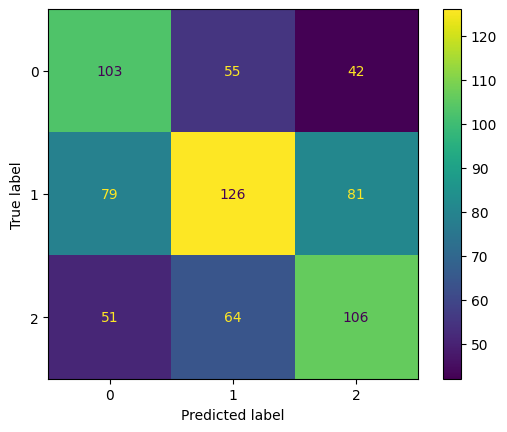

In [10]:
y_pred = model.predict(X_test)

print("F1 score: ", f1_score(y_test, y_pred, average='micro'))

cf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2])
display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=model.classes_)
display.plot()
plt.show()

## 2. Tunning to choose most approriate model

### Split dataset

In [11]:
train_df = df.sample(frac=0.9, random_state=42)
test_df = df.drop(train_df.index)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3181 entries, 325 to 3439
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   textID               3181 non-null   object
 1   text                 3181 non-null   object
 2   sentiment            3181 non-null   object
 3   Time of Tweet_noon   3181 non-null   int32 
 4   Time of Tweet_night  3181 non-null   int32 
 5   Age of User_21-30    3181 non-null   int32 
 6   Age of User_31-45    3181 non-null   int32 
 7   Age of User_46-60    3181 non-null   int32 
 8   Age of User_60-70    3181 non-null   int32 
 9   Age of User_70-100   3181 non-null   int32 
 10  label                3181 non-null   int32 
dtypes: int32(8), object(3)
memory usage: 198.8+ KB


### Tunning

I use cross-validation for tunning

In [12]:
from hyperparameter_tunning import *

# Construct suggestion instances
n_features_suggest = IntVariableSuggestion("n_features", 100, 300)
nb_var_smooth_suggest = FloatVariableSuggestion("NB_var_smoothing", 1e-12, 1e-6)
tunning_params = [n_features_suggest, nb_var_smooth_suggest]

# train_df_1 = train_df.sample(frac=0.8, random_state=42)
# val_df = train_df.drop(train_df_1.index)

def training_func(train_df, n_features, nb_var_smooth):
    hashing_vector =  feature_extraction.hasing_vectorize(train_df['text'], n_features)
    dummy_vector = train_df.iloc[:, 4:10].to_numpy()

    X_train = np.concatenate((hashing_vector.toarray(), dummy_vector), axis=1)
    y_train = train_df['label']

    # Evaluation hyperparamter
    model = GaussianNB(var_smoothing=nb_var_smooth)
    model.fit(X_train, y_train)
    return model

def evaluation_func(model, test_df, n_features, nb_var_smooth):
    hashing_vector =  feature_extraction.hasing_vectorize(test_df['text'], n_features)
    dummy_vector = test_df.iloc[:, 4:10].to_numpy()

    X_test = np.concatenate((hashing_vector.toarray(), dummy_vector), axis=1)
    
    y_pred = model.predict(X_test)
    y_test = test_df['label']

    return f1_score(y_pred=y_pred, y_true=y_test, average='micro')

tunning_model = Tunning(tunning_params, training_func, evaluation_func)
study = tunning_model.cross_validation_tunning(df=train_df, k_folds=15, n_trials=50, direction='maximize', timeout=120)

d:\BK University\Semester 242\Machine Learning\ML_capybara\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-03-05 10:13:07,502] A new study created in memory with name: no-name-86822fa8-82b9-40bc-926f-aa36f225071b
[I 2025-03-05 10:13:08,052] Trial 0 finished with value: 0.45803732246729856 and parameters: {'n_features': 256, 'NB_var_smoothing': 2.0660066913471495e-07}. Best is trial 0 with value: 0.45803732246729856.
[I 2025-03-05 10:13:08,630] Trial 1 finished with value: 0.45333362860601767 and parameters: {'n_features': 268, 'NB_var_smoothing': 8.624572680281159e-07}. Best is trial 0 with value: 0.45803732246729856.
[I 2025-03-05 10:13:09,137] Trial 2 finished with value: 0.4533262467889096 and parameters: {'n_features': 131, 'NB_var_smoothing': 2.7388382819789052e-08}. Best is trial 0 with value: 

### Evaluate result

In [13]:
n_features, var_smoothing = study.best_params.values()
print(f"n_features: {n_features} and NB var smoothing: {var_smoothing}")

features_vector =  feature_extraction.hasing_vectorize(train_df['text'], n_features)
X_train = features_vector.toarray()

# Evaluation hyperparamter
model = GaussianNB(var_smoothing=var_smoothing)
model.fit(X_train, train_df['label'])
model

n_features: 126 and NB var smoothing: 8.055305864308297e-07


GaussianNB(var_smoothing=8.055305864308297e-07)

### Testing in `test_df`

F1 score:  0.44192634560906513


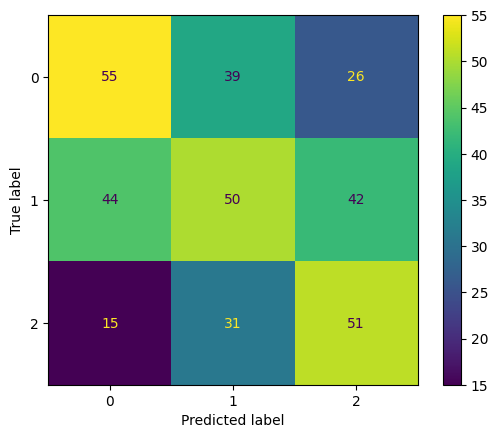

In [14]:
test_features_vector =  feature_extraction.hasing_vectorize(test_df['text'], n_features)
X_test = test_features_vector.toarray()
y_pred = model.predict(X_test)
y_test = test_df['label']

print("F1 score: ", f1_score(y_test, y_pred, average='micro'))

cf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2])
display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=model.classes_)
display.plot()
plt.show()

# B. Construct Gaussian NB model with Tf-idf vector

## 1. Build sample model

### Vectorize the column `text`

In [15]:
tfidf_count = feature_extraction.tfidf_vectorize(df['text'],
                                                max_gram= MAX_GRAMS, 
                                                max_features= MAX_FEATURES
                                            )
tfidf_count.shape

(3534, 1000)

In [16]:
scaler = StandardScaler(with_mean=False)
tfidf_count = scaler.fit_transform(tfidf_count)

In [17]:
df_tfidf_count = tfidf_count.toarray()
dummy_vector = df.iloc[:, 4:10].to_numpy()
feature_vector = np.concatenate((df_tfidf_count, dummy_vector), axis=1)

feature_vector.shape

(3534, 1006)

In [18]:
X_train, X_test, y_train, y_test = feature_extraction.split_dataset(feature_vector, np.array(df['label'].to_list()))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2827, 1006), (707, 1006), (2827,), (707,))

### Fitting `Gaussian Naive Bayes` model

In [19]:
model = GaussianNB()
model.fit(X_train, y_train)
model

GaussianNB()

### Evaluation model

F1 score:  0.4639321074964639


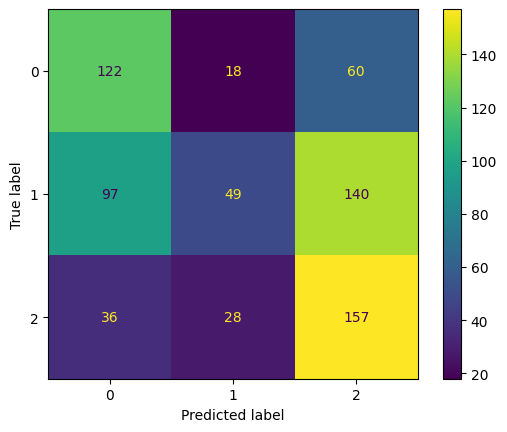

In [20]:
y_pred = model.predict(X_test)

print("F1 score: ", f1_score(y_test, y_pred, average='micro'))

cf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2])
display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=model.classes_)
display.plot()
plt.show()

## 2. Hyperparamater Tunning

In [ ]:
from hyperparameter_tunning import *

# Construct suggestion instances
max_features_suggest = IntVariableSuggestion("max_features", 100, 1000)
max_gram_suggest = IntVariableSuggestion("max_grams", 2, 4)
nb_var_smooth_suggest = FloatVariableSuggestion("NB_var_smoothing", 1e-12, 1e-6)
tunning_params = [max_features_suggest, max_gram_suggest, nb_var_smooth_suggest]

def training_func(train_df, max_features, max_grams, nb_var_smooth):
    # Extract TFIDF features
    features_vector =  feature_extraction.tfidf_vectorize(train_df['text'], max_features, max_grams)
    scaler = StandardScaler(with_mean=False)
    features_vector = scaler.fit_transform(features_vector)
    dummy_vector = train_df.iloc[:, 4:10].to_numpy()

    X_train = np.concatenate((features_vector.toarray(), dummy_vector), axis=1)
    y_train = train_df['label']

    # Evaluation hyperparamter
    model = GaussianNB(var_smoothing=nb_var_smooth)
    model.fit(X_train, y_train)
    return model

def evaluation_func(model, test_df, max_features, max_grams, nb_var_smooth):
    features_vector =  feature_extraction.tfidf_vectorize(test_df['text'], max_features, max_grams)
    dummy_vector = test_df.iloc[:, 4:10].to_numpy()

    X_test = np.concatenate((features_vector.toarray(), dummy_vector), axis=1)
    y_pred = model.predict(X_test)
    y_test = test_df['label']

    return f1_score(y_pred=y_pred, y_true=y_test, average='micro')

tunning_model = Tunning(tunning_params, training_func, evaluation_func)
study = tunning_model.cross_validation_tunning(train_df, k_folds=15, n_trials=50, direction='maximize')

[I 2025-03-05 10:13:28,667] A new study created in memory with name: no-name-8bbbebb8-8f3e-4f56-b439-e7f90e87544f
[I 2025-03-05 10:13:31,698] Trial 0 finished with value: 0.4099418312811881 and parameters: {'max_features': 973, 'max_grams': 2, 'NB_var_smoothing': 6.864024730509084e-07}. Best is trial 0 with value: 0.4099418312811881.
[I 2025-03-05 10:13:34,779] Trial 1 finished with value: 0.4099418312811881 and parameters: {'max_features': 863, 'max_grams': 2, 'NB_var_smoothing': 7.946788765076229e-07}. Best is trial 0 with value: 0.4099418312811881.
[I 2025-03-05 10:13:37,776] Trial 2 finished with value: 0.40616677001210616 and parameters: {'max_features': 110, 'max_grams': 3, 'NB_var_smoothing': 6.899255419034042e-08}. Best is trial 0 with value: 0.4099418312811881.
[I 2025-03-05 10:13:40,757] Trial 3 finished with value: 0.4099418312811881 and parameters: {'max_features': 489, 'max_grams': 2, 'NB_var_smoothing': 3.7547800303985404e-07}. Best is trial 0 with value: 0.40994183128118

In [ ]:
max_features, max_grams, var_smoothing = study.best_params.values()
print(f"max_features: {n_features}, max_grams: {max_grams} and NB var smoothing: {var_smoothing}")

features_vector =  feature_extraction.tfidf_vectorize(train_df['text'], max_features, max_grams)
dummy_vector = train_df.iloc[:, 4:10].to_numpy()

X_train = np.concatenate((features_vector.toarray(), dummy_vector), axis=1)

# Evaluation hyperparamter
model = GaussianNB(var_smoothing=var_smoothing)
model.fit(X_train, train_df['label'])
model

max_features: 168, max_grams: 2 and NB var smoothing: 7.401333306770286e-07


GaussianNB(var_smoothing=7.401333306770286e-07)

### Testing in `test_df`

F1 score:  0.3909348441926346


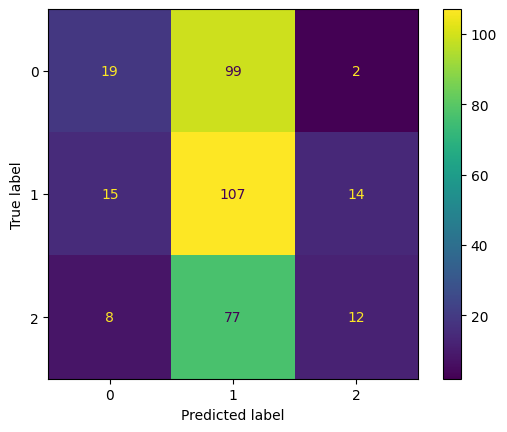

In [ ]:
features_vector =  feature_extraction.tfidf_vectorize(test_df['text'], max_features, max_grams)
dummy_vector = test_df.iloc[:, 4:10].to_numpy()

X_test = np.concatenate((features_vector.toarray(), dummy_vector), axis=1)

y_pred = model.predict(X_test)
y_test = test_df['label']

print("F1 score: ", f1_score(y_test, y_pred, average='micro'))

cf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2])
display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=model.classes_)
display.plot()
plt.show()